In [5]:
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

### FUNCTIONS:

In [6]:
def shift_relative_time(event, plot=False):
    """
    Shift all channels in an event by the value of the first trigger signal time.

    NOTE: Might be too expensive, as you have to search throughout all of the time arrays to find the minimum time value.
    Perhaps its better to not search? Looking at the generated voltage vs. time arrays, all channel seem to have the same starting time?

    Parameters:
    event (np.array): Event containing channels with voltage vs. time arrays.
    plot (bool): If True, generates before and after subplots (for debugging purposes).
    """
    
    # Plot before the shift, if requested
    if plot:
        _, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(event[0][0], event[0][1])
        ax[0].set_title('Before Shift')
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Voltage')

    # Find the minimum time across all channels
    min_time = min(np.min(channel[0]) for channel in event)

    # Subtract min_time from the time values of each channel
    for channel in event:
        channel[0] -= min_time

    # Plot after the shift, if requested
    if plot:
        ax[1].plot(event[0][0], event[0][1])
        ax[1].set_title('After Shift')
        ax[1].set_xlabel('Time (ns)')
        ax[1].set_ylabel('Voltage (V)')
        plt.tight_layout()
        plt.savefig('Before_and_after_shift.png')

In [7]:
def bin_v(channel, nbins, hilbert = False, method='max', plot=False):
    """
    Bin voltage vs. time data. The bin values are calculated according to different methods.

    A big issue is that if the different channels effectively HAVE different time domains, then the different channels will contain
    different bin sizes. We could make all bins the same size, but then graphs will have more or less bins, or we could keep it like this.
    Parameters:
    channel (np.array): Channel array containing two numpy arrays of time (pos [0]) and voltage (pos [1]).
    method (str): Modifies bin values according to the method. 
                  'max' - Bins Hilbert envelope according to the local maximum of their respective time bins.
                  'avg' - Bins Hilbert envelope according to the average of their respective time bins.
    plot (bool): If True, plots the original Hilbert envelope and the binned data.

    Returns:
    np.array: Binned time array
    np.array: Binned Hilbert envelope array
    float: Time of a bin.
    """
    
    time_arr = channel[0]
    voltage_arr = channel[1]

    if hilbert is True:
        # Obtain Hilbert envelope
        v_arr = np.abs(hilbert(voltage_arr))
    else:
        v_arr = voltage_arr

    bin_width = len(voltage_arr) // nbins
    bin_dt = time_arr[bin_width]-time_arr[0]
    binned_time = time_arr[:nbins * bin_width:bin_width]

    if method == 'max':
        binned = np.array([np.max(v_arr[i:i+bin_width]) for i in range(0, nbins * bin_width, bin_width)])
    elif method == 'avg':
        binned = np.array([np.mean(v_arr[i:i+bin_width]) for i in range(0, nbins * bin_width, bin_width)])
    else:
        raise ValueError(f"Invalid method '{method}'. Use 'max' or 'avg'.")

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(time_arr, v_arr, label='Original Hilbert Envelope', alpha=0.7)
        plt.plot(binned_time, binned, 'o-', label=f'Binned Hilbert Envelope ({method})', color='red')
        plt.xlabel(f'Time (ns), one bin = {bin_dt} ns')
        plt.ylabel('Hilbert Envelope (V)')
        plt.title('Original vs Binned Hilbert Envelope')
        plt.legend()
        plt.grid(True)
        plt.savefig('Original vs Binned Hilbert Envelope.png')

    return binned_time, binned, bin_dt

In [8]:
def calculate_noise(voltage_arr, plot=False):
    """
    Calculate the RMS noise of a voltage array and optionally plot the voltage data.

    The noise is calculated by:
    1. Identifying the peak signal (maximum value) in the array.
    2. Defining a range around the peak, covering 25% of the array's length to the left and right of the peak.
    3. Extracting the noise subarrays from the portions of the array outside this range.
    4. Calculating the RMS noise from the concatenated noise subarrays.

    Parameters:
    voltage_arr (np.array): Array of voltage values.
    plot (bool): If True, plots the voltage data with noise range markers (For debugging purposes).

    Returns:
    float: The RMS noise value.
    """
    
    peak_idx = np.argmax(voltage_arr)
    quarter_len = len(voltage_arr) // 4

    # Define the range around the peak signal
    left_idx = max(0, peak_idx - quarter_len)
    right_idx = min(len(voltage_arr), peak_idx + quarter_len)

    # Extract noise subarrays and concatenate them
    noise_subarray = np.concatenate((voltage_arr[:left_idx], voltage_arr[right_idx:]))

    # Calculate RMS noise
    rms_noise = np.sqrt(np.mean(noise_subarray ** 2))

    # For testing purposes:
    if plot:
        # Plotting the original voltage data
        plt.figure(figsize=(10, 6))
        plt.plot(voltage_arr, label='Voltage Data', color='blue')
        
        # Mark the start and end indices of the noise range
        plt.axvline(x=left_idx, color='red', linestyle='--', label='Left Noise Index')
        plt.axvline(x=right_idx, color='green', linestyle='--', label='Right Noise Index')
        
        # Highlighting the noise areas on the plot
        plt.fill_between(range(left_idx), voltage_arr[:left_idx], color='red', alpha=0.3)
        plt.fill_between(range(right_idx, len(voltage_arr)), voltage_arr[right_idx:], color='green', alpha=0.3)
        
        plt.xlabel('Index')
        plt.ylabel('Voltage (V)')
        plt.title('Voltage Data with Noise Range')
        plt.legend()
        plt.grid(True)
        plt.savefig('Voltage Data with Noise Range.png')

    return rms_noise

In [9]:
def bin_matrix(event,bins = 25, plotting = False, hilb = False):
    row1 = bin_v(event['data'][0],bins, hilbert = hilb)[1]
    row2 = bin_v(event['data'][1],bins, hilbert = hilb)[1]
    row3 = bin_v(event['data'][2],bins, hilbert = hilb)[1]
    row4 = bin_v(event['data'][3],bins, hilbert = hilb)[1]
    bintime = row1[3]
    bintime_ns = bintime*(10**6)
    matrix = np.array([row1,row2,row3,row4])

    binned_dict = {'data' : matrix, 'bintime' : bintime_ns}

    if plotting:
        plt.figure(figsize=(10, 6))
        # Creating the heatmap
        plt.imshow(matrix, cmap='viridis', interpolation='nearest',aspect=5)
        plt.colorbar()  # adding color bar to show the scale
        plt.title("Heatmap of voltage on 4 channels")
        plt.xlabel(f"Bin Value:{bintime_ns: .3g} ns    ;    Mean SNR:{event['mean_integrated_power']: .3g}")
        y_ticks = [0, 1, 2, 3]  # Custom y-tick positions
        y_labels = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']  # Custom y-tick labels
        plt.yticks(y_ticks, y_labels)
        plt.show()

    return binned_dict

In [10]:
import numpy as np

# Define the arrays
arrays = [
    np.array([1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9]),
]

# Create an empty matrix with zero rows and the same number of columns
M = np.empty((0, 3))

# Progressively stack the arrays
for arr in arrays:
    M = np.vstack((M, arr))

print(M)




[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


In [11]:
def plot_image(event):
    matrix = event['data']
    bintime_ns = event['bin_time']

    plt.figure(figsize=(10, 6))
    # Creating the heatmap
    plt.imshow(matrix, cmap='viridis', interpolation='nearest',aspect=5)
    plt.colorbar()  # adding color bar to show the scale
    plt.title("Heatmap of voltage on 4 channels")
    plt.xlabel(f"Bin Value:{bintime_ns: .3g} ns    ;    Mean SNR:{event['mean_SNR']: .3g}")
    y_ticks = [0, 1, 2, 3]  # Custom y-tick positions
    y_labels = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']  # Custom y-tick labels
    plt.yticks(y_ticks, y_labels)
    plt.show()


In [12]:
import os
import pickle

event_data_to_append = {}

def save_events(file_path='data/event_data.pkl',events_in=None):
    """
    Save events in a dictionary. If a dictionary already exists, it will append the events to the end of the dictionary.
    Otherwise, it will create the pickled dictionary in the file_path.

    Parameters:
    file_path (String) location of dictionary, or location where to create it.
    events_in (dict) python dictionary from which to append the events or to save.
    """
    # Check if the file exists
    if os.path.exists(file_path):
        # Load and return the dictionary
        with open(file_path, 'rb') as file:
            event_dict = pickle.load(file)

        start_i = max(event_dict.keys())

        # Function to shift keys by a given number
        def shift_keys(d, shift_amount):
            return {k + shift_amount: v for k, v in d.items()}
        
        shifted_events_in = shift_keys(events_in,start_i+1)
        new_event_dict = {**event_dict, **shifted_events_in}

        with open(file_path, 'wb') as file:
            pickle.dump(new_event_dict, file)
    else:
        # Save the event dictionary to file
        with open(file_path, 'wb') as file:
            pickle.dump(events_in, file)

In [13]:
def calculate_SNR(matrix, plot = False):
    SNR = 0
    for i,channel in enumerate(matrix):
        SNR += np.max(channel)/calculate_noise(channel, plot)

    SNR_mean = SNR/4

    return SNR_mean

In [14]:
def plot_raw(event):
    # Create subplots: 2 rows, 2 columns (for 4 channels)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    event = event['data']

    # Loop through the first 4 channels and plot their data
    for i,ch in enumerate(event):  # Assuming there are at least 4 channels
        time = ch[0]  # Time values for the channel
        voltage = ch[1]  # Voltage values for the channel

        # Plot the time vs voltage for each channel in the appropriate subplot
        axes[i].plot(time, voltage)
        axes[i].set_title(f'Channel {i + 1}')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Voltage (V)')
    
    # Adjust layout to avoid overlapping labels
    plt.tight_layout()
    plt.show()

# Example usage with event data
# event = [ [ [time1, voltage1], [time2, voltage2], ... ], ... ]


### TESTING:

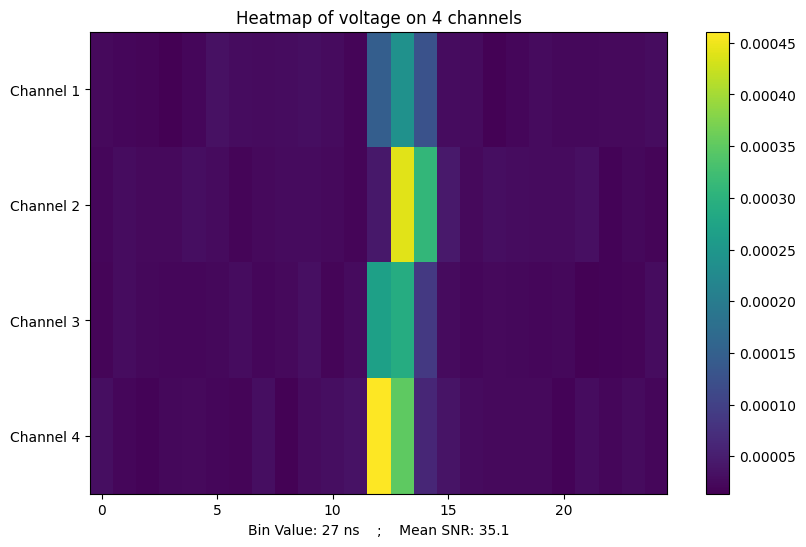

In [19]:
with open('data/event_dict.pkl', 'rb') as file:
    trace = pickle.load(file)

trace.keys()

plot_image(trace[17])

In [16]:
matrix = bin_matrix(trace2[1],50,True)
snr_mean = calculate_SNR(matrix,True)
print(snr_mean)

NameError: name 'trace2' is not defined

In [ ]:
# Function testing block

with open('data/saved_dictionary.pkl', 'rb') as file:
    trace1 = pickle.load(file) # WARNING: The pickle module is not secure. Only unpickle data you trust.

# def shift_keys(d, shift_amount):
#     return {k + shift_amount: v for k, v in d.items()}

# print(tracey)

# tracey = shift_keys(tracey,-1)

# print(tracey)

# with open('data/saved_dictionary.pkl', 'wb') as file:
#     pickle.dump(tracey, file) # WARNING: The pickle module is not secure. Only unpickle data you trust.

save_events('data/event_dict.pkl',trace1)

with open('data/event_dict.pkl','rb') as file:
    trace2_changed = pickle.load(file)


trace2_changed[0].shape

(4, 2, 672)

In [ ]:
with open('data/event_dict.pkl', 'rb') as file:
    event_dict = pickle.load(file)

bin_matrix(event,bin)

NameError: name 'event' is not defined